In [1]:
import urllib
import re
import sys
import logging
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.signalmanager import dispatcher
from scrapy import signals

In [2]:
logging.disable(sys.maxsize)

In [3]:
class GoogleSearch(scrapy.Spider):
    
    name = 'GoogleSearch'
    
    def start_requests(self):
        url = self.base_url.format(f"{urllib.parse.quote(' '.join(['metal', 'e-waste', 'batteries']))}", 10 * (self.page-1))
        yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
                
        search_items = response.css('.fP1Qef').extract()
        searches = dict()
        
        for search in search_items:
            selector = scrapy.Selector(text=search)
            title = selector.xpath('//a/h3/div//text()').get()
            link = selector.css('a::attr(href)').get()
            link = urllib.parse.parse_qs(urllib.parse.urlsplit(link).query)['q'][0]
            if title not in searches.keys():
                searches[title] = link

        print(len(searches))
        print(searches)
        
        return searches
        

In [4]:
class WebsiteKeywordAnalysis(scrapy.Spider):
    
    name = 'WebsiteKeywordAnalysis'
    
    def start_requests(self):
        yield scrapy.Request(url=self.base_url, callback=self.parse)
        
    def parse(self, response):
        elements = response.css('div::text, h1::text, h2::text, h3::text, h4::text, h5::text, h6::text, a::text, p::text').extract()
        combined_string = ' '.join(elements)
        yield { self.website: combined_string }

In [5]:
google_search_results = None

def google_search_results_listener(signal, sender, item, response, spider):
    global google_search_results
    google_search_results = item

In [6]:
keyword_analysis_results = dict()

def keyword_analysis_results_listener(signal, sender, item, response, spider):
    global keyword_analysis_results
    keyword_analysis_results[list(item.keys())[0]] = list(item.values())[0]

In [7]:
dispatcher.connect(google_search_results_listener, signal=signals.item_scraped)
process = CrawlerProcess()
process.crawl(GoogleSearch, base_url="https://www.google.com.au/search?q={0}&start={1}", page=1)
process.start()

10
{'Battery Recycling in the City of Melbourne area': 'https://recyclingnearyou.com.au/batteries/MelbourneVIC', 'Battery Recycling in the Moreland City Council area': 'https://recyclingnearyou.com.au/batteries/MorelandVIC', 'Recycle e-waste | Sustainability Victoria': 'https://www.sustainability.vic.gov.au/recycling-and-reducing-waste/at-home/recycling-at-home/e-waste', 'How to dispose of or recycle batteries and e-waste | AGL Discover': 'https://discover.agl.com.au/your-home/dispose-recycle-batteries-e-waste/', 'Scrap Battery Recycling: What You Need to Know': 'https://www.collinsrecycling.com.au/hows-and-whys-of-scrap-battery-recycling/', 'Closing the loop on energy metals - CSIRO': 'https://www.csiro.au/en/work-with-us/industries/mining-resources/resourceful-magazine/issue-21/closing-the-loop', 'Car Battery Disposal And Recycling Melbourne': 'https://supermetal.com.au/car-battery-disposal-and-recycling-melbourne/', 'Laptop Battery Ewaste Removal - 1800Ewaste': 'https://www.ewaste.c

In [8]:
dispatcher.connect(keyword_analysis_results_listener, signal=signals.item_scraped)

for website_name, url in google_search_results.items():
    
    if "twisted.internet.reactor" in sys.modules:
        del sys.modules["twisted.internet.reactor"]
        
    process = CrawlerProcess()
    process.crawl(WebsiteKeywordAnalysis, base_url=url, website=website_name)
    process.start()

In [9]:
stop_words = [word.strip() for word in open('../Resources/stop-words.txt', 'r').readlines()]

def count_occurrences(text):
    count_vec = CountVectorizer(stop_words=stop_words)
    X = count_vec.fit_transform([text])
    return [X, count_vec]

In [10]:
def get_keyword_occurrences_as_dict(occurrences, vectorizer):
    keywords = vectorizer.get_feature_names_out()
    occurrences = occurrences.toarray()[0]
    return dict(zip(keywords, occurrences))

In [11]:
circle_mask = np.array(Image.open('../Resources/circle.png'))

def draw_word_cloud(keyword_analysis_dict):
    wordcloud = WordCloud(width = 1000, height = 666, random_state=1, background_color='white', colormap='inferno', collocations=False, mask=circle_mask).generate_from_frequencies(keyword_analysis_dict)
    plt.figure(figsize=(10, 15))
    plt.imshow(wordcloud)
    plt.axis("off")

Battery Recycling in the City of Melbourne area
Battery Recycling in the Moreland City Council area
Recycle e-waste | Sustainability Victoria
Scrap Battery Recycling: What You Need to Know
Closing the loop on energy metals - CSIRO
Laptop Battery Ewaste Removal - 1800Ewaste
It's time to get serious about recycling lithium-ion batteries - C&EN
Designing batteries for easier recycling could avert a looming e ...


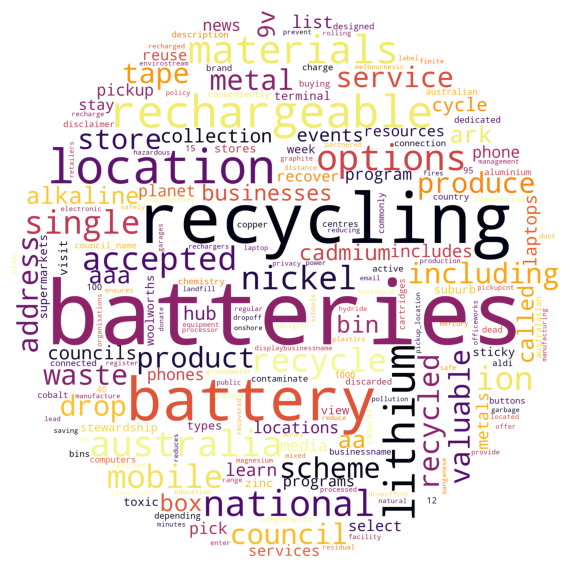

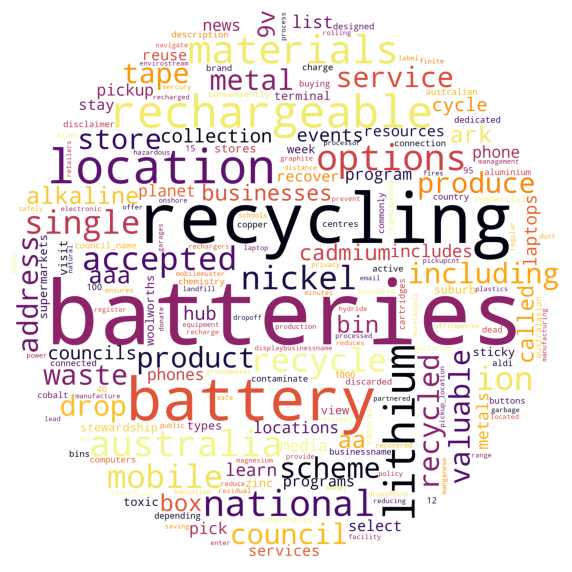

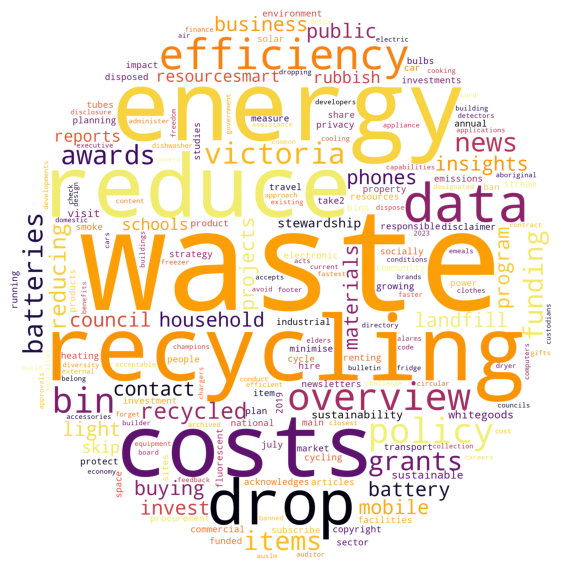

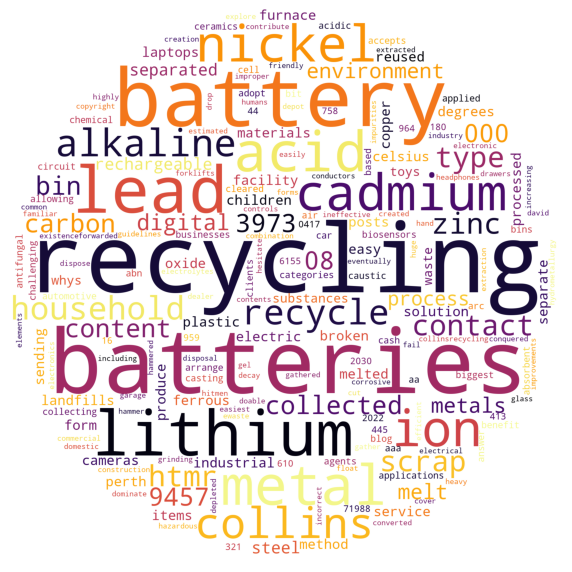

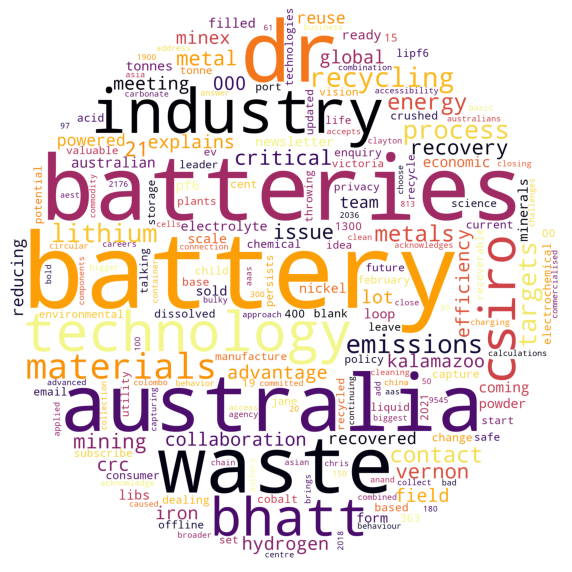

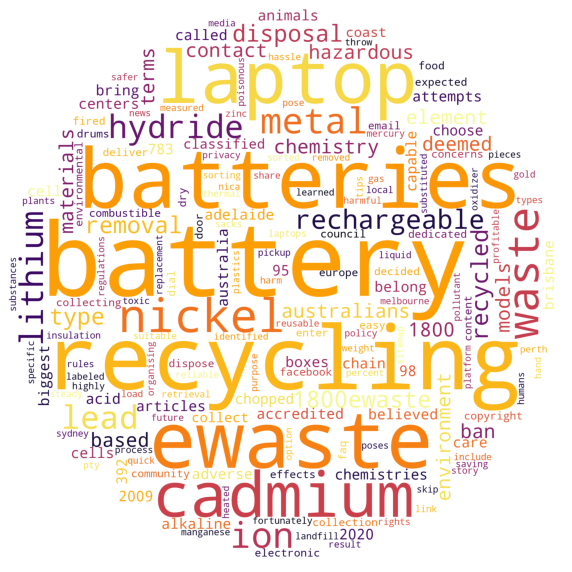

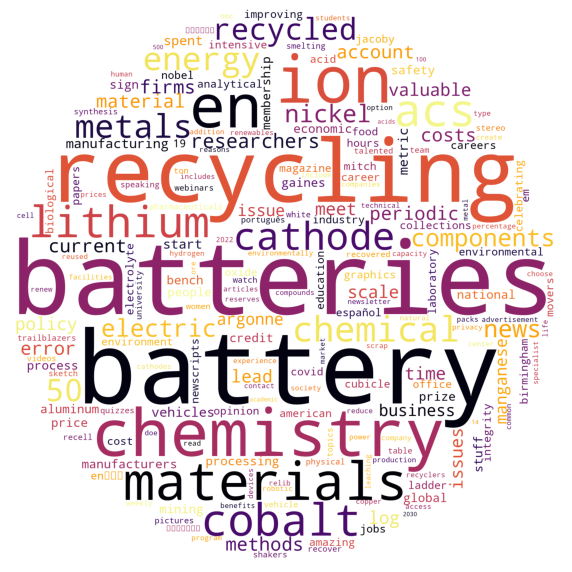

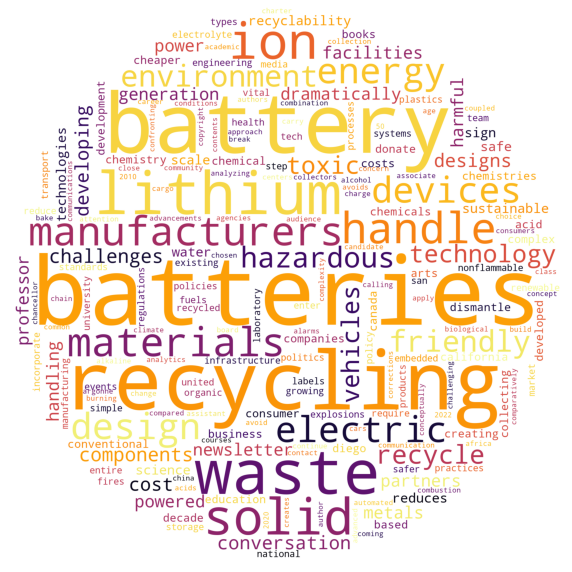

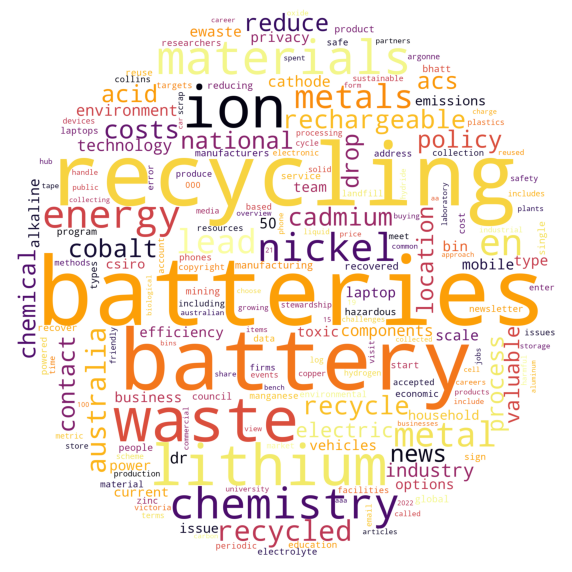

In [12]:
all_text = ""

for website, keyword_text in keyword_analysis_results.items(): 
    keyword_analysis = count_occurrences(keyword_text)
    keyword_analysis_dict = get_keyword_occurrences_as_dict(keyword_analysis[0], keyword_analysis[1])
    draw_word_cloud(keyword_analysis_dict)
    print(website)
    all_text = all_text + keyword_text
    
keyword_analysis = count_occurrences(all_text)
keyword_analysis_dict = get_keyword_occurrences_as_dict(keyword_analysis[0], keyword_analysis[1])
draw_word_cloud(keyword_analysis_dict)